<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-03-17 

CPython 2.7.10
IPython 5.3.0

numpy 1.12.0
matplotlib 2.0.0
scipy 0.15.1
pandas 0.19.2
sklearn 0.18.1
mlxtend 0.5.1


# Formatting for PyUnfold use
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Fraction correctly identified](#Fraction-correctly-identified)
4. [Spectrum](#Spectrum)
5. [Unfolding](#Unfolding)
6. [Feature importance](#Feature-importance)

In [2]:
%matplotlib inline
from __future__ import division, print_function
from collections import defaultdict
import numpy as np
from scipy.sparse import block_diag
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import json

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold, StratifiedKFold

import composition as comp
import composition.analysis.plotting as plotting
    
color_dict = {'light': 'C0', 'heavy': 'C1', 'total': 'C2',
             'P': 'C0', 'He': 'C1', 'O': 'C3', 'Fe':'C4'}

/home/jbourbeau/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Define analysis free parameters
[ [back to top](#top) ]

Whether or not to train on 'light' and 'heavy' composition classes, or the individual compositions

In [3]:
comp_class = True
comp_list = ['light', 'heavy'] if comp_class else ['P', 'He', 'O', 'Fe']

Get composition classifier pipeline

In [4]:
pipeline_str = 'GBDT'
pipeline = comp.get_pipeline(pipeline_str)

Define energy binning for this analysis

In [5]:
energybins = comp.analysis.get_energybins()

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature transformation

In [6]:
sim_train, sim_test = comp.preprocess_sim(comp_class=comp_class, return_energy=True)

sim quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:  0.776  0.776
              InIceQualityCuts:  0.786   0.75
                 num_hits_1_60:  0.999   0.75


Selecting the following features:
	$\cos(\theta_{\mathrm{Lap}})$
	$\log_{10}(S_{\mathrm{125}})$
	$\log_{10}$(dE/dX)
	
Number training events = 208926
Number testing events = 89540


In [7]:
data = comp.preprocess_data(comp_class=comp_class, return_energy=True)

data quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:    1.0    1.0
              InIceQualityCuts:    0.9    0.9
                 num_hits_1_60:    1.0    0.9




/home/jbourbeau/cr-composition/composition/dataframe_functions.py:137: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])


Selecting the following features:
	$\cos(\theta_{\mathrm{Lap}})$
	$\log_{10}(S_{\mathrm{125}})$
	$\log_{10}$(dE/dX)
	
Number testing events = 7212805


In [8]:
is_finite_mask = np.isfinite(data.X)
not_finite_mask = np.logical_not(is_finite_mask)
finite_data_mask = np.logical_not(np.any(not_finite_mask, axis=1))
data = data[finite_data_mask]

In [9]:
unfolding_df = pd.DataFrame()

## Spectrum
[ [back to top](#top) ]

### Number of events observed

In [10]:
num_particles, num_particles_err = comp.analysis.get_num_particles(sim_train, data, pipeline, comp_list)

In [11]:
unfolding_df['counts_light'] = num_particles['light']
unfolding_df['counts_heavy'] = num_particles['heavy']
unfolding_df['counts_err_light'] = num_particles_err['light']
unfolding_df['counts_err_heavy'] = num_particles_err['heavy']

### Block diagonal response matrix and error

In [12]:
pipeline.fit(sim_train.X, sim_train.y)
test_predictions = pipeline.predict(sim_test.X)
true_comp = sim_train.le.inverse_transform(sim_test.y)
pred_comp = sim_train.le.inverse_transform(test_predictions)

In [13]:
response_list = []
response_err_list = []
sim_bin_idxs = np.digitize(sim_test.log_energy, energybins.log_energy_bins) - 1
data_bin_idxs = np.digitize(data.log_energy, energybins.log_energy_bins) - 1
energy_bin_idx = np.unique(sim_bin_idxs)
# energy_bin_idx = energy_bin_idx[1:]
print(energy_bin_idx)
# print(energybins.energy_midpoints.shape)
for bin_idx in energy_bin_idx:
    if (bin_idx == -1) or (bin_idx == energybins.energy_midpoints.shape[0]): continue
    sim_bin_mask = sim_bin_idxs == bin_idx
    data_bin_mask = data_bin_idxs == bin_idx
    response_mat = confusion_matrix(true_comp[sim_bin_mask], pred_comp[sim_bin_mask],
            labels=comp_list)
    # Transpose response matrix to get MC comp on x-axis and reco comp on y-axis
    response_mat = response_mat.T
    # Get response matrix statistical error
    response_mat_err = np.sqrt(response_mat)/response_mat.sum(axis=0, keepdims=True)
    response_err_list.append(response_mat_err)
    # Normalize along MC comp axis to go from counts to probabilities
    response_mat = response_mat.astype(float)/response_mat.sum(axis=0, keepdims=True)
    response_list.append(response_mat)
block_response = block_diag(response_list).toarray()
block_response = np.flipud(block_response)
print('block_response = \n{}'.format(block_response))
block_response_err = block_diag(response_err_list).toarray()
block_response_err = np.flipud(block_response_err)
print('block_response_err = \n{}'.format(block_response_err))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
block_response = 
[[ 0.          0.          0.         ...,  0.          0.21108179
   0.67726161]
 [ 0.          0.          0.         ...,  0.          0.78891821
   0.32273839]
 [ 0.          0.          0.         ...,  0.75128205  0.          0.        ]
 ..., 
 [ 0.          0.          0.71929825 ...,  0.          0.          0.        ]
 [ 0.2663406   0.75186474  0.         ...,  0.          0.          0.        ]
 [ 0.7336594   0.24813526  0.         ...,  0.          0.          0.        ]]
block_response_err = 
[[ 0.          0.          0.         ...,  0.          0.02359966
   0.04069271]
 [ 0.          0.          0.         ...,  0.          0.04562432
   0.02809077]
 [ 0.          0.          0.         ...,  0.04389037  0.          0.        ]
 ..., 
 [ 0.          0.          0.01798808 ...,  0.          0.          0.        ]
 [ 0.01088238  0.01933587  0.         ...,  0.          0.     

In [14]:
np.savetxt('block_response.txt', block_response)
np.savetxt('block_response_err.txt', block_response_err)

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


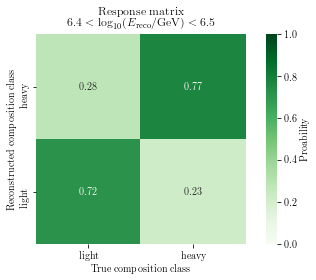

In [15]:
fig, ax = plt.subplots()
h = np.flipud(block_response)
sns.heatmap(h[2:4, 2:4], annot=True, ax=ax, cmap='Greens', square=True,
           xticklabels=['light', 'heavy'], yticklabels=['light', 'heavy'],
           cbar_kws={'label': 'Proability'}, vmin=0, vmax=1)
# h = np.rot90(block_response)
# h = np.flipud(block_response)
# plt.imshow(h[:2, :2], cmap='Greens', origin='lower', extent=(0, h.shape[0], 0, h.shape[0]))
# plt.colorbar(label='Probability')
ax.invert_yaxis()
plt.xlabel('True composition class')
plt.ylabel('Reconstructed composition class')
plt.title('Response matrix \n $6.4 < \log_{10}(E_{\mathrm{reco}}/\mathrm{GeV}) < 6.5$')
plt.savefig('/home/jbourbeau/public_html/figures/response-matrix.png')

### Priors array

In [46]:
from icecube.weighting.weighting import from_simprod
from icecube.weighting.fluxes import GaisserH3a, GaisserH4a, Hoerandel5

In [47]:
df_sim = comp.load_dataframe(datatype='sim', config='IC79')

sim quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:  0.776  0.776
              InIceQualityCuts:  0.786   0.75
                 num_hits_1_60:  0.999   0.75




In [48]:
simlist = np.unique(df_sim['sim'])
for i, sim in enumerate(simlist):
    _, sim_files = comp.simfunctions.get_level3_sim_files(sim)
    num_files = len(sim_files)
    if i == 0:
        generator = num_files*from_simprod(int(sim))
    else:
        generator += num_files*from_simprod(int(sim))

In [70]:
priors_list = ['h3a', 'h4a', 'antih3a', 'Hoerandel5', 'antiHoerandel5', 'uniform', 'alllight', 'allheavy']
# model_ptypes = {}
# model_ptypes['h3a'] = {'light': [2212, 1000020040], 'heavy': [1000070140, 1000130270, 1000260560]}
# model_ptypes['h4a'] = {'light': [2212, 1000020040], 'heavy': [1000070140, 1000130270, 1000260560]}
# model_ptypes['Hoerandel5'] = {'light': [2212, 1000020040], 'heavy': [1000070140, 1000130270, 1000260560]}

In [73]:
priors = defaultdict(list)
for flux, name in zip([GaisserH3a(), GaisserH3a(), GaisserH4a(), Hoerandel5(), Hoerandel5()],
                      ['h3a', 'antih3a', 'h4a', 'Hoerandel5', 'antiHoerandel5']):
    priors_raw = defaultdict(list)
    for energy_mid in energybins.energy_midpoints:
        energy = [energy_mid]*5
        ptype = [2212, 1000020040, 1000070140, 1000130270, 1000260560]
        weights = flux(energy, ptype)
#         weights = flux(energy, ptype)/generator(energy, ptype)
        light_prior = weights[:2].sum()/weights.sum()
        heavy_prior = weights[2:].sum()/weights.sum()
        if 'anti' in name:
            priors_raw['light'].append(heavy_prior)
            priors_raw['heavy'].append(light_prior)
        else:
            priors_raw['light'].append(light_prior)
            priors_raw['heavy'].append(heavy_prior)
        priors[name].extend([light_prior, heavy_prior])
    unfolding_df['{}_priors_light'.format(name)] = priors_raw['light']
    unfolding_df['{}_priors_heavy'.format(name)] = priors_raw['heavy']
    
unfolding_df['uniform_priors_light'] = [0.5]*len(priors_raw['light'])
unfolding_df['uniform_priors_heavy'] = [0.5]*len(priors_raw['heavy'])

unfolding_df['alllight_priors_light'] = [0.9]*len(priors_raw['light'])
unfolding_df['alllight_priors_heavy'] = [0.1]*len(priors_raw['heavy'])

unfolding_df['allheavy_priors_light'] = [0.1]*len(priors_raw['light'])
unfolding_df['allheavy_priors_heavy'] = [0.9]*len(priors_raw['heavy'])

In [74]:
unfolding_df

,counts_light,counts_heavy,counts_err_light,counts_err_heavy,h3a_priors_light,h3a_priors_heavy,h4a_priors_light,h4a_priors_heavy,Hoerandel5_priors_light,Hoerandel5_priors_heavy,uniform_priors_light,uniform_priors_heavy,alllight_priors_light,alllight_priors_heavy,allheavy_priors_light,allheavy_priors_heavy,antih3a_priors_light,antih3a_priors_heavy,antiHoerandel5_priors_light,antiHoerandel5_priors_heavy
0,359917,333373,599.930829,577.384621,0.612155,0.387845,0.621130,0.378870,0.525211,0.474789,0.5,0.5,0.9,0.1,0.1,0.9,0.387845,0.612155,0.474789,0.525211
1,246830,247362,496.819887,497.355004,0.594538,0.405462,0.604184,0.395816,0.505380,0.494620,0.5,0.5,0.9,0.1,0.1,0.9,0.405462,0.594538,0.494620,0.505380
2,166187,171104,407.660398,413.647193,0.572835,0.427165,0.583304,0.416696,0.479212,0.520788,0.5,0.5,0.9,0.1,0.1,0.9,0.427165,0.572835,0.520788,0.479212
3,111450,111037,333.841280,333.222148,0.546380,0.453620,0.557857,0.442143,0.445752,0.554248,0.5,0.5,0.9,0.1,0.1,0.9,0.453620,0.546380,0.554248,0.445752
4,71146,71072,266.732075,266.593323,0.514642,0.485358,0.527341,0.472659,0.404594,0.595406,0.5,0.5,0.9,0.1,0.1,0.9,0.485358,0.514642,0.595406,0.404594
5,43352,46386,208.211431,215.374093,0.477441,0.522559,0.491597,0.508403,0.356213,0.643787,0.5,0.5,0.9,0.1,0.1,0.9,0.522559,0.477441,0.643787,0.356213
6,24185,31339,155.515273,177.028246,0.435256,0.564744,0.451106,0.548894,0.302353,0.697647,0.5,0.5,0.9,0.1,0.1,0.9,0.564744,0.435256,0.697647,0.302353
7,13594,20151,116.593310,141.954218,0.389548,0.610452,0.407295,0.592705,0.246277,0.753723,0.5,0.5,0.9,0.1,0.1,0.9,0.610452,0.389548,0.753723,0.246277
8,7618,12939,87.281155,113.749725,0.342902,0.657098,0.362676,0.637324,0.192315,0.807685,0.5,0.5,0.9,0.1,0.1,0.9,0.657098,0.342902,0.807685,0.192315
9,4381,8385,66.189123,91.569646,0.298739,0.701261,0.320568,0.679432,0.144557,0.855443,0.5,0.5,0.9,0.1,0.1,0.9,0.701261,0.298739,0.855443,0.144557


In [75]:
unfolding_df.to_csv('unfolding-dataframe.csv', index=False)

## Formatting for PyUnfold use

In [76]:
formatted_df = pd.DataFrame()

In [77]:
counts_formatted = []
priors_formatted = defaultdict(list)
for index, row in unfolding_df.iterrows():
    counts_formatted.extend([row['counts_light'], row['counts_heavy']])
    for priors_name in priors_list:
        priors_formatted[priors_name].extend([row[priors_name+'_priors_light'], row[priors_name+'_priors_heavy']])
formatted_df['counts'] = counts_formatted

for key, value in priors_formatted.iteritems():
    formatted_df[key+'_priors'] = value

In [78]:
print(formatted_df.head())
formatted_df.to_csv('formatted-dataframe.csv', index=False)

     counts  allheavy_priors  h3a_priors  h4a_priors  alllight_priors  \
0  359917.0              0.1    0.612155    0.621130              0.9   
1  333373.0              0.9    0.387845    0.378870              0.1   
2  246830.0              0.1    0.594538    0.604184              0.9   
3  247362.0              0.9    0.405462    0.395816              0.1   
4  166187.0              0.1    0.572835    0.583304              0.9   

   Hoerandel5_priors  uniform_priors  antih3a_priors  antiHoerandel5_priors  
0           0.525211             0.5        0.387845               0.474789  
1           0.474789             0.5        0.612155               0.525211  
2           0.505380             0.5        0.405462               0.494620  
3           0.494620             0.5        0.594538               0.505380  
4           0.479212             0.5        0.427165               0.520788  


In [32]:
counts_formatted = []
for light_counts, heavy_counts in zip(unfolding_df['counts_light'], unfolding_df['counts_heavy']):
    counts_formatted.extend([light_counts, heavy_counts])
formatted_df['counts'] = counts_formatted

In [25]:
formatted_df

,counts,Hoerandel5_priors,h3a_priors,h4a_priors,uniform_priors
0,359917.0,0.726850,0.794854,0.800502,0.5
1,333373.0,0.273150,0.205146,0.199498,0.5
2,246830.0,0.707918,0.781775,0.788016,0.5
3,247362.0,0.292082,0.218225,0.211984,0.5
4,166187.0,0.682663,0.765092,0.772107,0.5
5,171104.0,0.317337,0.234908,0.227893,0.5
6,111450.0,0.649301,0.743865,0.751899,0.5
7,111037.0,0.350699,0.256135,0.248101,0.5
8,71146.0,0.606033,0.717028,0.726405,0.5
9,71072.0,0.393967,0.282972,0.273595,0.5


In [18]:
with open('pyunfold_dict.json', 'w') as outfile:
    data = {'counts': counts_observed,
            'block_response':block_response.tolist(),
            'block_response_err':block_response_err.tolist()}
    for model in ['h3a', 'h4a', 'Hoerandel5']:
        data['priors_{}'.format(model)] = priors[model]
    json.dump(data, outfile)